## Title: Predicting Player Rank Categories Based on the Number of Seasons Active, Prize Money Won, Age, and Height Statistics of the Top 500 Players 


**Background Information:**
In tennis, player rankings are determined based on the number of points a player obtains. Players are able to acquire points through competing in tournaments. Winning higher-status tournaments, such as a Grand Slam, results in more points to be gained (2000 points). Additionally, winning tournaments lets players earn prize money, where like points, winning a higher-status tournament gives more prize money (Nag, 2022). Higher-ranking players are therefore more likely to have earned more prize money. Moreover, players who have competed in more seasons have had more opportunities to win tournaments, possibly indicating that they have a higher ranking. 


**Question:**
Can we use known player statistics, such as the number of seasons active, prize money, age, and height of the top 500 players to predict which category an unknown player will reside in? 



**Variables:** We will be using age, height, prize money won, and total seasons active to predict the rank of an unknown player. 75 percent of the data will be used to train our classifier, and 25 percent will be used to test it. We will visualize our results by using histograms to show the distribution of players based on different variables. 


We expect that individuals with a high rank will fulfill the following criteria: large number of seasons played, greater prize money earned,  age in their mid-20s, and taller height. Greater prize money earned is likely the strongest predictor for rank as it can be expected that greater prize money earned is correlated with more wins. 

A practical use of our findings could be that it would help identify skilled players when placing sports bets. Alternatively, this result could be used by tennis fans to identify upcoming stars in tennis. 
If given more physical attributes, it may be possible to predict the country of origin of the players using their physical trait

Bibliography:

Nag, U. (2022, April 5). Tennis rankings: Everything you need to no w. Olympics.Com. https://olympics.com/en/news/tennis-rankings-atp-wta-men-women-doubles-singles-system-grand-slam-olympics





Hadlich, G. (2019, November 12). What is the average height of tennis players? My Tennis HQ. https://mytennishq.com/what-is-the-average-height-of-tennis-players/s.




In [2]:
library(repr)
library(tidyverse)
library(tidymodels)
library(readxl)
library(janitor)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ ggplot2   3.5.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::

In [3]:
#loading data

set.seed(22)

tennis_data <- read_csv("Data/player_stats3.csv", skip = 1)


New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (24): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (14): ...1, Prize Money, Turned Pro, Seasons, Titles, Best Season, Retir...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# tidying the data -> removing unnecessary characters from rows

tennis_df <- tennis_data |>
    clean_names() |>
    select(age, current_rank, prize_money, height, seasons) |>
    separate(col = height, 
            into = c("height_cm", "discard"), 
           sep = " ") |>
    separate(col = current_rank, 
            into = c("rank", "discard_1"), 
           sep = " ") |>
    separate(col = age, 
            into = c("age", "discard_2"), 
           sep = " ") |>
    select(-discard_2, -discard_1, -discard) |>
    mutate(age = as.numeric(age),
           rank = as.numeric(rank),
           height_cm = as.numeric(height_cm)) |>
           arrange(desc(rank))


Warning message:
“Expected 2 pieces. Additional pieces discarded in 1 rows [59].”


In [5]:
# tidying the data -> calcualting means of columns to use them to replace NA values

means <- tennis_df |>
            select(age:seasons) |>
            map_dfr(mean, na.rm = TRUE)

tennis_df <- tennis_df |>
        replace_na(list(age = 25.96794, 
                        prize_money = 3416440, 
                        height_cm = 185.7913, 
                        seasons = 6.494652)) |>
    arrange(rank)

In [6]:
# tidying the data -> calculating values to be used for making the ranking categories


rank_quantile <- tennis_df |>
    select(rank) |>
    quantile(probs = c(0.25, 0.5, 0.75), na.rm = TRUE)

In [7]:
# tidying the data -> creating ranking category columns

print("Player Statistics")
category_columns <- tennis_df |>
    mutate(top_25_percent = rank < 125.5) |>
    mutate(top_25to50_percent = 125.5 < rank & rank < 249) |>
    mutate(top_50to75_percent = 249 < rank & rank < 372.5) |>
    mutate(bottom_25_percent = 372.5 < rank) 

tennis_df_longer <- category_columns |> 
    pivot_longer(cols = top_25_percent:bottom_25_percent, 
                 names_to = "category", 
                 values_to = "status") |>
    filter(status == "TRUE") |>
    select(-status) |>
    drop_na()
head(tennis_df_longer)
tail(tennis_df_longer)

[1] "Player Statistics"


age,rank,prize_money,height_cm,seasons,category
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
33,1,119601561,185,19,top_25_percent
32,2,139144944,188,17,top_25_percent
38,3,129231891,185,22,top_25_percent
23,4,10507693,198,5,top_25_percent
26,5,22132368,185,10,top_25_percent
21,6,10425605,193,4,top_25_percent


age,rank,prize_money,height_cm,seasons,category
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
24,493,3416440,185.7913,6.494652,bottom_25_percent
23,494,33471,185.0000,3.000000,bottom_25_percent
23,495,3416440,191.0000,6.494652,bottom_25_percent
21,498,27950,173.0000,6.494652,bottom_25_percent
20,499,82547,180.0000,1.000000,bottom_25_percent
23,500,129874,185.7913,6.494652,bottom_25_percent


In [8]:
# splitting data

tennis_split <- initial_split(tennis_df_longer, prop = 0.75, strata = category)
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)

**Process for Uploading, Cleaning, Wrangling, and Splitting Player Data:**

Before we began exploring our data, we first downloaded our top 500 player data set from Canvas. Upon review, we noticed many height values of players were missing, so to make the data more compatible and representable for analysis, we inputted missing values from the web. After this information was updated, we uploaded our data frame to JupiterLab, so we could read it into our notebook. 

After our data was loaded, we began cleaning up our data by removing spaces within the column names. Sequentially, we selected our desired predictor variables (age, current rank, prize money, height, and seasons), and tidied up cells to ensure only our intended value was in the cell. As many of the cells also contained units, we removed them by splitting the data inside the cells by spaces to create two new columns and later discarded the column that held the units. Furthermore, we used the as.numeric function to transform our age, rank, and height variables from character to double values. 

To account for NA values, we calculated the means for each category and replaced the empty spaces with these values. This ensured data was not lost during the classification process. 

As we planned to perform a categorization on our data, we then mutated the player ranks into one of four categories: top 25%, top 25% to 50%, bottom 50% to 75%, and bottom 25%. These category boundaries were determined using the quantile function on our dataset, which provided us with specific value ranges for each of the four categories which we could then use for mutating our data into each category. 

To finish tidying our, data pivot longer was used to put all of the players’ designated categories into one column. Once our data was tidy, we split 75% of our data into our training set and 25% into our testing set. 

The data frame displayed shows the outcome of our processes and summarizes each player's age, rank, total prize money won, height, seasons, and designated category. 

In [9]:
# summary table
print("Mean Summary Statistics of All 500 Players")
tennis_train_dbl <- tennis_train |>
    mutate(age = as.numeric(age)) |>
    mutate(prize_money = as.numeric(prize_money)) |>
    mutate(height_cm = as.numeric(height_cm)) |>
    mutate(seasons = as.numeric(seasons)) 

summary_table <- tennis_train_dbl |>
    select(age:seasons) |>
    map_dfr(mean, na.rm = TRUE) |>
    rename(mean_age = age,
          mean_prize_money = prize_money,
          mean_height_cm = height_cm,
          mean_seasons = seasons)
summary_table

[1] "Mean Summary Statistics of All 500 Players"


mean_age,rank,mean_prize_money,mean_height_cm,mean_seasons
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
25.87027,250.7486,3474670,185.4322,6.389225


In [10]:
# summary statistics of each category

print("Mean Player Statistics Based on Category")
summary_by_category <- tennis_df_longer |> 
    group_by(category) |> 
    summarize(age_mean = mean(age), average_rank = mean(rank), 
              prize_money_mean = mean(prize_money), 
              height_cm_mean = mean(height_cm), 
              average_seasons = mean(seasons))
summary_by_category

[1] "Mean Player Statistics Based on Category"


category,age_mean,average_rank,prize_money_mean,height_cm_mean,average_seasons
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bottom_25_percent,24.30645,434.98387,1566300,184.5171,5.254873
top_25_percent,27.39516,63.12903,8864071,186.3952,8.935484
top_25to50_percent,26.69106,187.00000,2056045,186.0308,6.072736
top_50to75_percent,25.44715,311.00000,1202990,185.0843,5.770705


In [11]:
# number of data points per category

print("Number of Players Per Category")
total_count_by_category <- tennis_df_longer |> 
    group_by(category) |> 
    summarize(number_per_category = n())

total_count_by_category

[1] "Number of Players Per Category"


category,number_per_category
<chr>,<int>
bottom_25_percent,124
top_25_percent,124
top_25to50_percent,123
top_50to75_percent,123


**Explanation of Tibbles:**

**Summary Statistics of All 500 Players:** This tibble shows the overall means for each of our variables for all of the players in our data set. Using these values, we can acquire a better understanding of overall trends and what an average player in the top 500's statistics would look like. 

**Player Statistics Based on Category:** This tibble provides insight into each category’s predictor variable means.  By observing these values we can make cross-group comparisons and observe how our predictions align with the data provided. 

**Number of Players Per Category:** This tibble displays how many players are within each category. By using this data, we can gauge player distributions between groups and gain an understanding of how many players our category averages were based on. 

In [ ]:
# data visualizations

# Distribution of Ages for Tennis Players
tennis_viz_histo_age <- tennis_train |> 
    ggplot(aes(x = age, fill = category)) + 
    geom_histogram(position = "dodge", bins = 10) + 
    facet_wrap(facets = vars(factor(category, levels = c("top_25_percent","top_25to50_percent","top_50to75_percent","top_100_percent")))) +
    xlab("Age (years)") +
    ylab("Count") +
    ggtitle("Distribution of Ages of Tennis Players") +
    labs(fill = "Category") +
    theme(text = element_text(size=13))
tennis_viz_histo_age

In [ ]:
# Distribution of Heights for Tennis Players
tennis_viz_histo_height <- tennis_train |> 
    ggplot(aes(x = height_cm, fill = category)) + 
    geom_histogram(position = "dodge", bins = 10) + 
    facet_wrap(facets = vars(factor(category, levels = c("top_25_percent","top_25to50_percent","top_50to75_percent","bottom_25_percent")))) +
    xlab("Height (cm)") +
    ylab("Count") +
    ggtitle("Distribution of Heights of Tennis Players") +
    labs(fill = "Category") +
    theme(text = element_text(size=13))
tennis_viz_histo_height


In [ ]:
# Distribution of Prize Money for Tennis Players
tennis_viz_histo_prize <- tennis_train |> 
    ggplot(aes(x = prize_money, fill = category)) + 
    geom_histogram(position = "dodge", bins = 10) + 
    facet_wrap(facets = vars(factor(category, levels = c("top_25_percent","top_25to50_percent","top_50to75_percent","bottom_25_percent")))) +
    xlab("Prize Money (USD)") +
    ylab("Count") +
    ggtitle("Distribution of Prize Money of Tennis Players") +
    labs(fill = "Category") +
    theme(text = element_text(size=13)) + 
    scale_x_log10(labels = label_comma()) +
    theme(axis.text.x = element_text(angle=90, vjust=.5, hjust=1))
tennis_viz_histo_prize

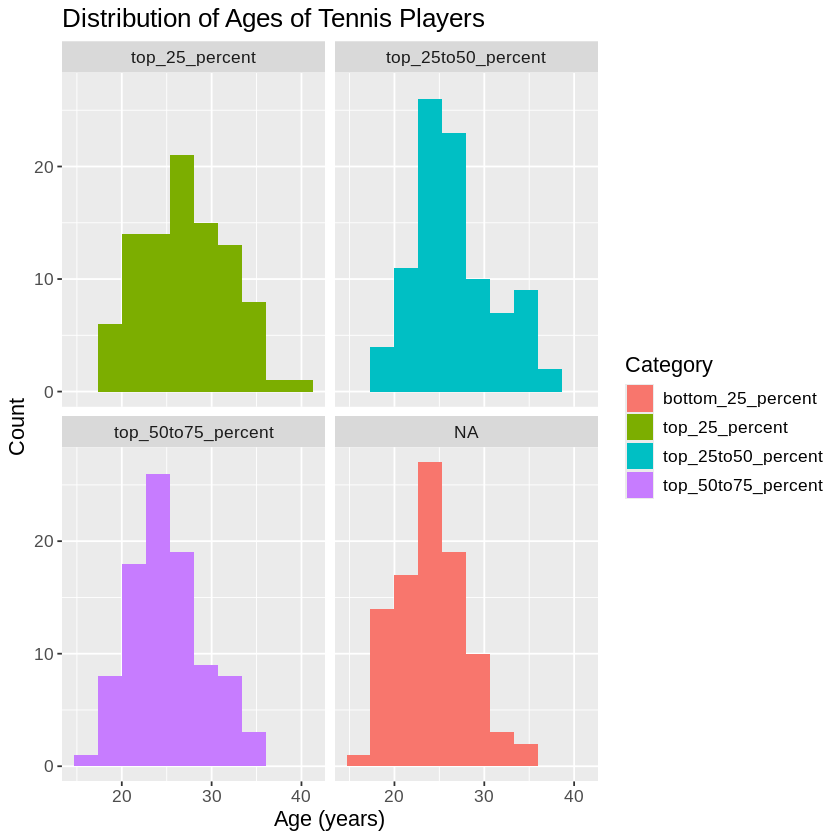

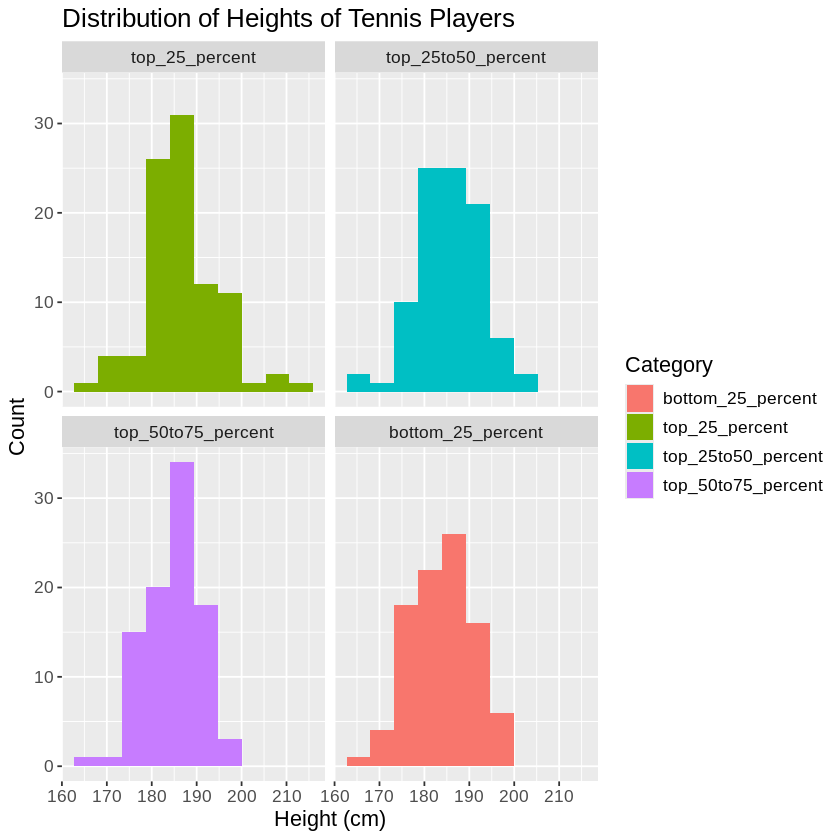

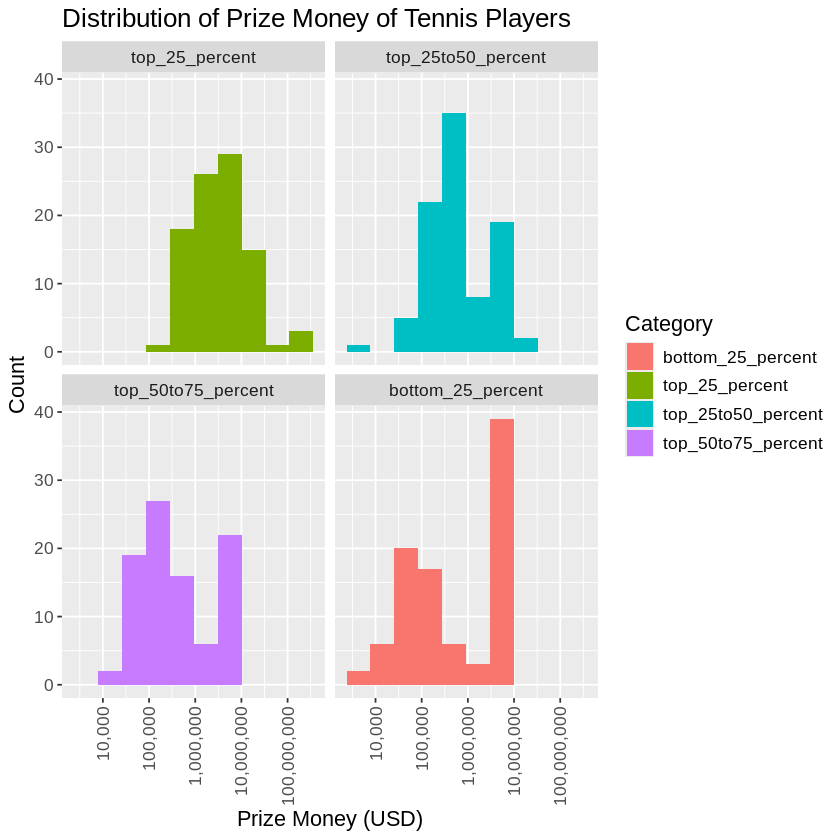

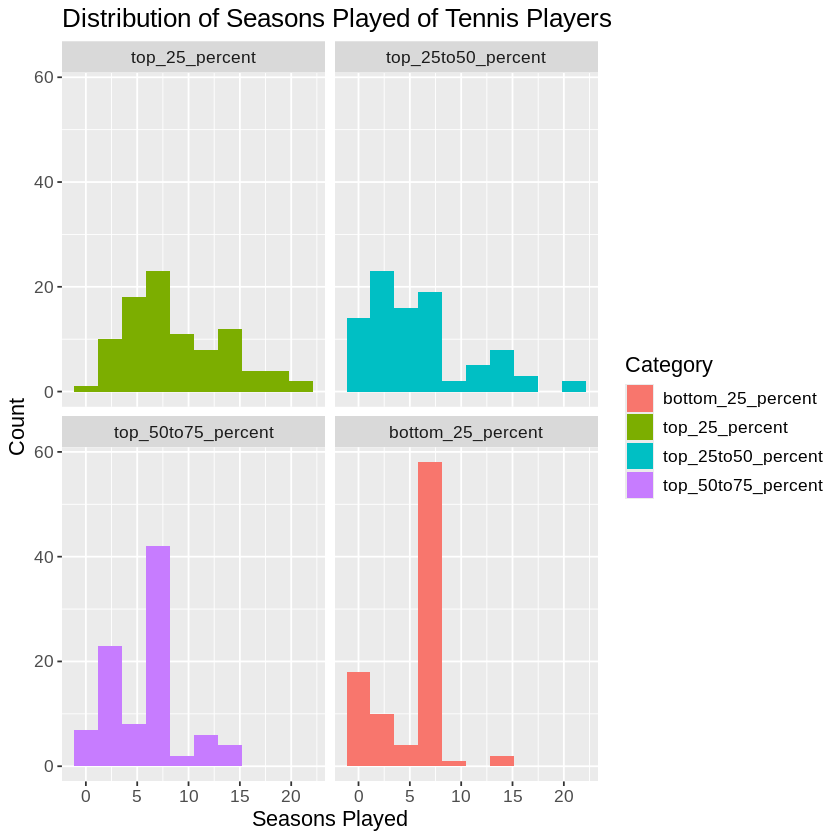

In [26]:
# Distribution of Seasons Played for Tennis Players
tennis_viz_histo_seasons <- tennis_train |> 
    ggplot(aes(x = seasons, fill = category)) + 
    geom_histogram(position = "dodge", bins = 10) + 
    facet_wrap(facets = vars(factor(category, levels = c("top_25_percent","top_25to50_percent","top_50to75_percent","bottom_25_percent")))) +
    xlab("Seasons Played") +
    ylab("Count") +
    ggtitle("Distribution of Seasons Played of Tennis Players") +
    labs(fill = "Category") +
    theme(text = element_text(size=13))
tennis_viz_histo_seasons

In [25]:
#scaling and centering data

tennis_recipe <- recipe(category ~ age + prize_money + height_cm + seasons , data = tennis_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

In [14]:
#making the recipe 
tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

#making the v-fold and grid values 
tennis_vfold <- vfold_cv(tennis_train, v = 10, strata = category)

grid_values <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

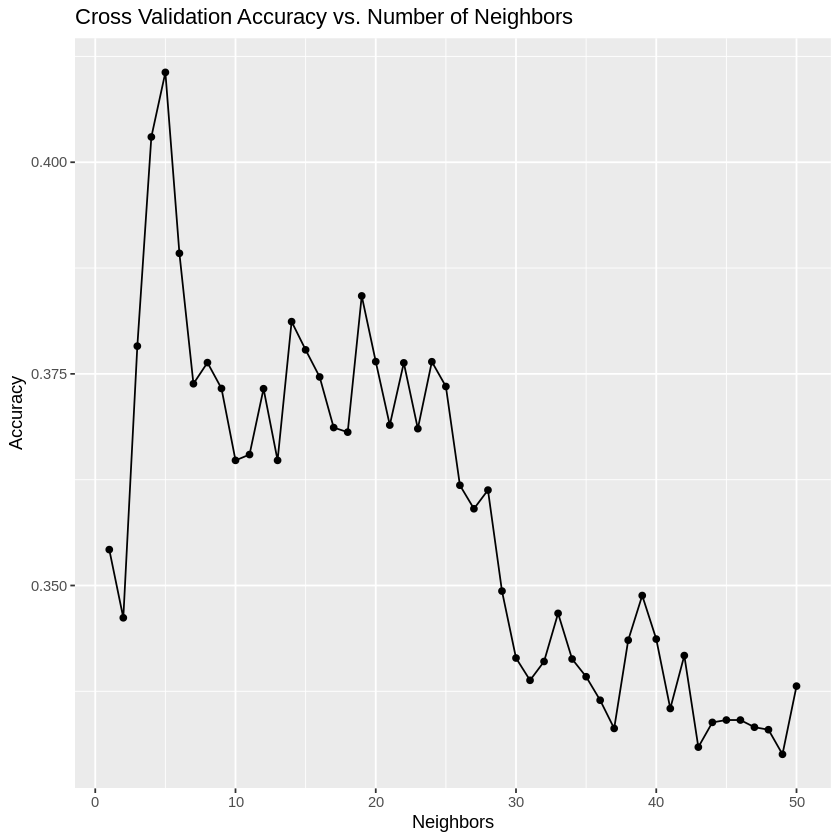

In [15]:
#making the workflow
tennis_workflow <- workflow() |>
    add_recipe(tennis_recipe) |>
    add_model(tennis_spec) |>
    tune_grid(resamples = tennis_vfold, grid = grid_values) |>
    collect_metrics() |>
    filter(.metric == "accuracy")


#making a plot to display cross validation accuracy vs. number of neighbours 
cross_val_plot <- tennis_workflow |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    xlab("Neighbors") +
    ylab("Accuracy") +
    ggtitle("Cross Validation Accuracy vs. Number of Neighbors")
cross_val_plot



In [16]:
library(forcats)

tennis_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |>
       set_engine("kknn") |>
       set_mode("classification")

tennis_workflow_final <- workflow() |>
    add_recipe(tennis_recipe) |>
    add_model(tennis_spec_final) |>
    fit(data = tennis_train)

tennis_predictions <- predict(tennis_workflow_final, tennis_test) |>
    bind_cols(tennis_test) |>
    mutate(category = as_factor(category)) |>
    mutate(.pred_class = fct_relevel(.pred_class, "top_25_percent", "top_25to50_percent", "top_50to75_percent", "bottom_25_percent"))

tennis_metrics <- tennis_predictions |>
  metrics(truth = category, estimate = .pred_class) |>
  filter(.metric == "accuracy") 

tennis_metrics

tennis_mat <- tennis_predictions |> 
       conf_mat(truth = category, estimate = .pred_class)
tennis_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4354839


                    Truth
Prediction           top_25_percent top_25to50_percent top_50to75_percent
  top_25_percent                 12                  6                  6
  top_25to50_percent             10                 11                  6
  top_50to75_percent              2                  8                 12
  bottom_25_percent               7                  6                  7
                    Truth
Prediction           bottom_25_percent
  top_25_percent                     4
  top_25to50_percent                 3
  top_50to75_percent                 5
  bottom_25_percent                 19